In [631]:
#!pip install np_utils
#!pip install spacy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import spacy
# import string
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
from imblearn.over_sampling import SMOTE
from keras.models import Model
from keras.layers import Input, Embedding, SimpleRNN, LSTM, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, RNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


#### 1. Data Preparation
Load dataset into pandas.

In [632]:
# Load dataset into pandas
data = pd.read_excel('../Data/Legal Cases.xlsx')
data.head()

,S/N,CASE TITLE,SUIT NO,CITATION,Altered_STORY,STORY,ISSUES
0,NaN,UKPABI v. UKPABI & ORS,CA/OW/571/2018,(2019) LPELR-48481(CA),INTRODUCTION: This appeal borders on civil pr...,INTRODUCTION: \n \n This appeal borders on civ...,Effect of a ground of appeal from which no iss...
1,NaN,EKWUGHA v. STATE,CA/OW/576C/2018,(2020) LPELR-50629(CA),INTRODUCTION: This appeal borders on the Offe...,INTRODUCTION: \n \n This appeal borders on the...,Position of the law on a no case submission\n ...
2,NaN,ROCHE CONSTRUCTION (NIG) LTD & ANOR v. ENYIDEDE,CA/OW/58/2015,(2017) LPELR-42438(CA),INTRODUCTION: &nbsp;This appeal borders on Ci...,INTRODUCTION: \n \n &nbsp;This appeal borders ...,Whether a party is allowed to formulate more i...
3,NaN,CHARLES v. COP ABIA STATE,CA/OW/58/2020,(2021) LPELR-56547(CA),INTRODUCTION: This appeal borders on enforceme...,INTRODUCTION: \n \n This appeal borders on enf...,Position of the law on remanding an accused pe...
4,NaN,UKAEGBU v. OGBUISI & ANOR,CA/OW/58M/2019(R),(2020) LPELR-49719(CA),INTRODUCTION: This is a ruling on an applicati...,INTRODUCTION: \n \n This is a ruling on an app...,Effect of failure to make reference to and/or ...


In [633]:
data.shape

(500, 7)

#### Data Cleaning

In [634]:
# Checking for missing values
data.isna().sum()

S/N              500
CASE TITLE         0
SUIT NO            0
CITATION           0
Altered_STORY      1
STORY              1
ISSUES             0
dtype: int64

In [635]:
# Dropping the S/N columns and rows with missing values
data.drop('S/N', axis=1, inplace=True)
data = data.dropna(subset=['STORY', 'Altered_STORY'])

# Checking for missing values after dropping row with missing values
data.isna().sum()

CASE TITLE       0
SUIT NO          0
CITATION         0
Altered_STORY    0
STORY            0
ISSUES           0
dtype: int64

##### Exploratory Data Analysis

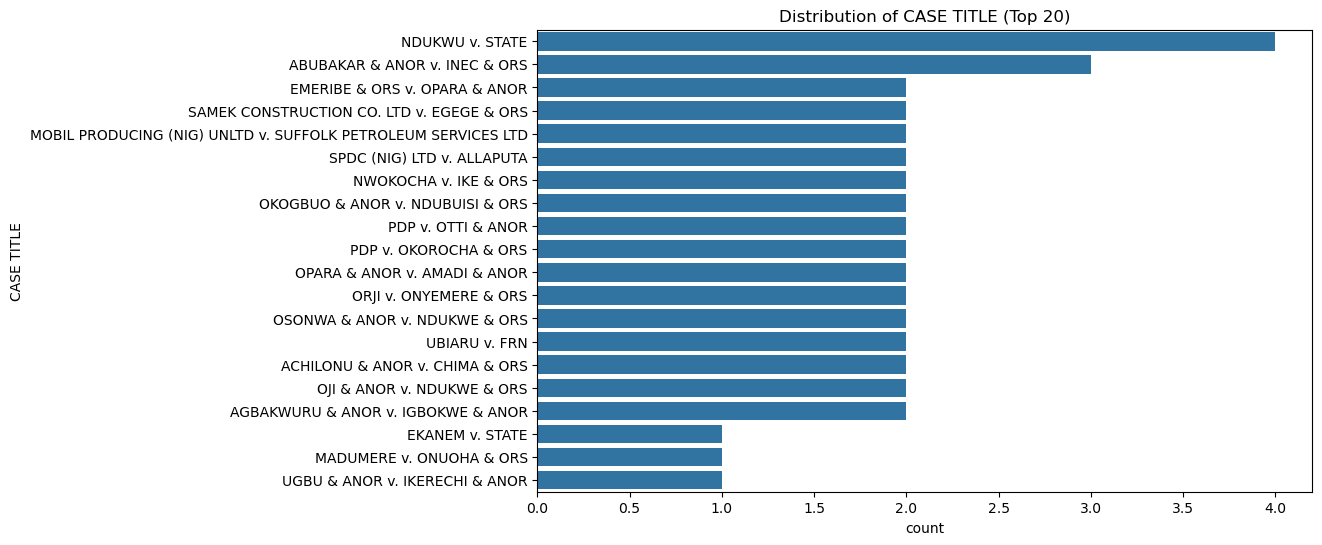

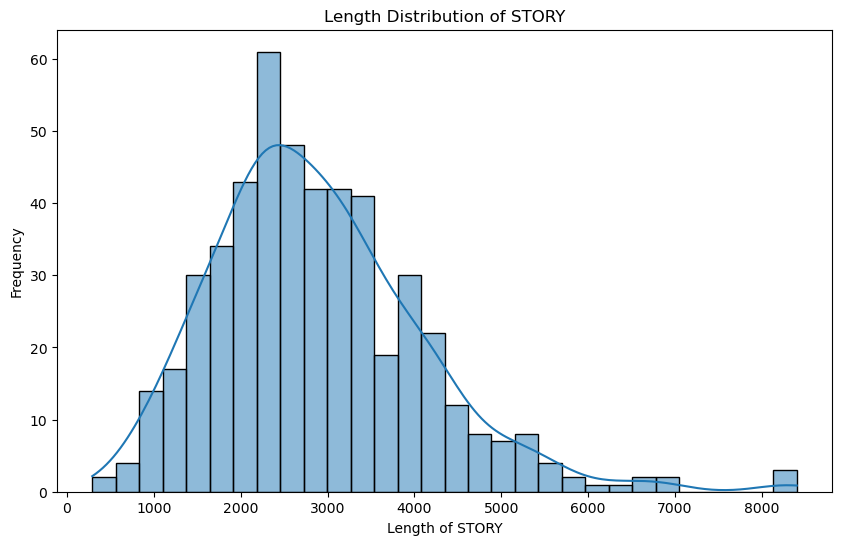

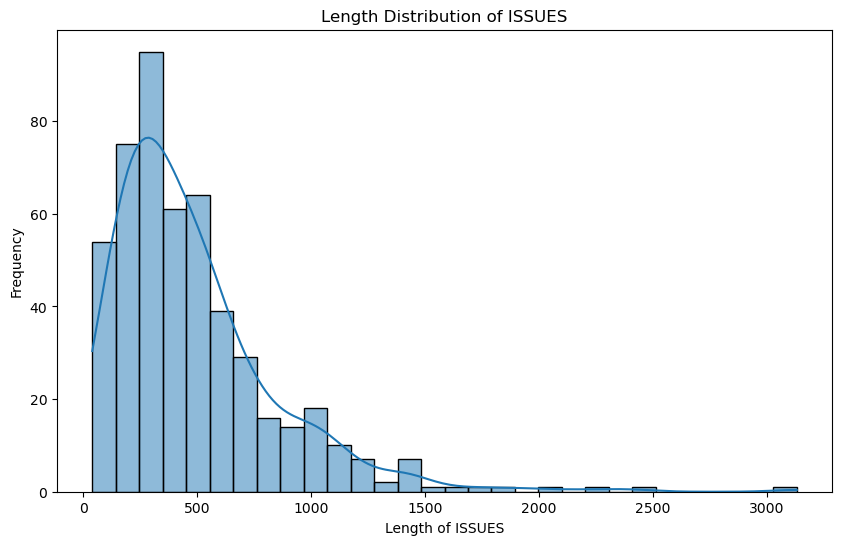

In [636]:
# Convert all entries in STORY and ISSUES columns to strings
data['STORY'] = data['STORY'].astype(str)
data['ISSUES'] = data['ISSUES'].astype(str)

# Plot the distribution of CASE TITLE (displaying only top 20 for better visualization)
plt.figure(figsize=(10, 6))
sns.countplot(y=data['CASE TITLE'], order=data['CASE TITLE'].value_counts().iloc[:20].index)
plt.title('Distribution of CASE TITLE (Top 20)')
plt.show()

# Plot the length distribution of STORY
data['STORY_LENGTH'] = data['STORY'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data['STORY_LENGTH'], bins=30, kde=True)
plt.title('Length Distribution of STORY')
plt.xlabel('Length of STORY')
plt.ylabel('Frequency')
plt.show()

# Plot the length distribution of ISSUES
data['ISSUES_LENGTH'] = data['ISSUES'].apply(len)
plt.figure(figsize=(10, 6))
sns.histplot(data['ISSUES_LENGTH'], bins=30, kde=True)
plt.title('Length Distribution of ISSUES')
plt.xlabel('Length of ISSUES')
plt.ylabel('Frequency')
plt.show()

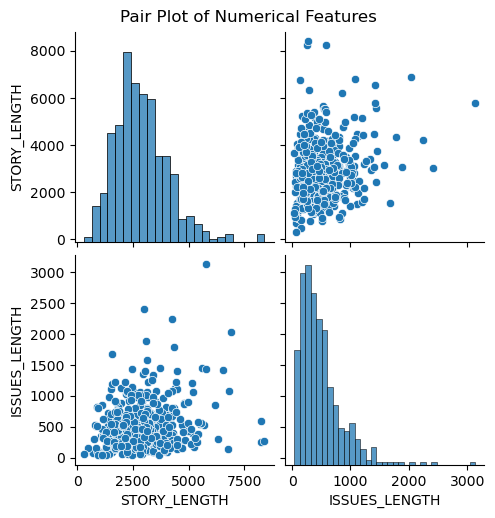

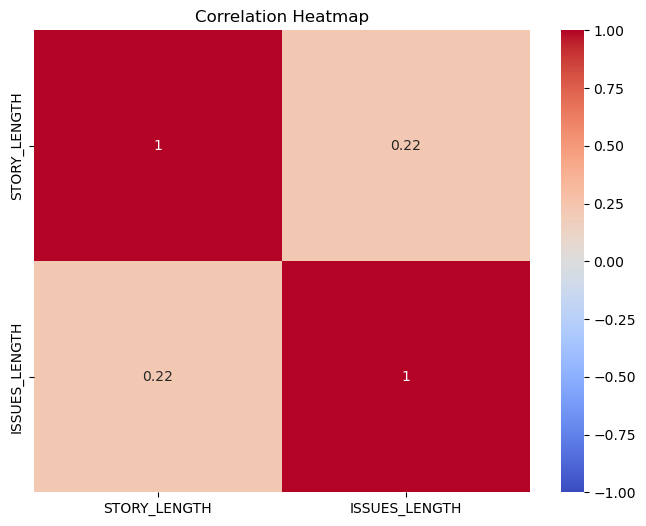

In [637]:
# Ensure STORY and ISSUES are treated as strings and calculate their lengths
data['STORY'] = data['STORY'].astype(str)
data['ISSUES'] = data['ISSUES'].astype(str)
data['STORY_LENGTH'] = data['STORY'].apply(len)
data['ISSUES_LENGTH'] = data['ISSUES'].apply(len)

# Create a pair plot for numerical features
sns.pairplot(data[['STORY_LENGTH', 'ISSUES_LENGTH']])
plt.suptitle('Pair Plot of Numerical Features', y=1.02)
plt.show()

# Calculate the correlation matrix
correlation_matrix = data[['STORY_LENGTH', 'ISSUES_LENGTH']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

#### Feature Engineering

In [638]:
# Splitting the Story column in INTRODUCTION, FACTS, ISSUES, HELD and DECISION.
data[['INTRODUCTION', 'FACTS', 'ISSUE', 'HELD', 'DECISION']] = data['Altered_STORY'].str.split('FACTS:|ISSUES:|HELD:|DECISION:', expand=True)

# Remove the word 'INTRODUCTION from INTRODUCTION column
data['INTRODUCTION'] = data['INTRODUCTION'].str.replace('INTRODUCTION:', "")

# Strip extra white spaces from all columns
data = data.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

# Correct all wrong spellings
data['DECISION'] = data['DECISION'].str.replace('.', "")
replacements = {'Partly granted': 'Partly Granted', 'Granteed': 'Granted', 'Dismissec': 'Dismissed', np.nan: None}
data['DECISION'] = data['DECISION'].replace(replacements)

# Drop rows that have NaN values in the DECISION column
data = data.dropna(subset=['DECISION'])

data['DECISION'].unique()

array(['Dismissed', 'Partly Granted', 'Granted'], dtype=object)

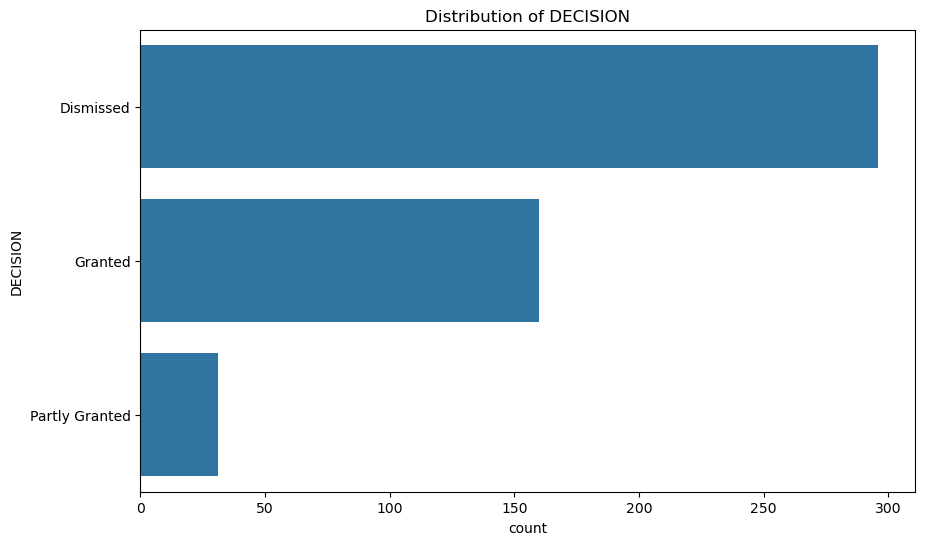

In [639]:
# Plot the distribution of DECISION

plt.figure(figsize=(10, 6))
sns.countplot(y=data['DECISION'], order=data['DECISION'].value_counts().index)
plt.title('Distribution of DECISION')
plt.show()

#### Text Preprocessing

In [640]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.metrics import classification_report  # Import classification_report

[nltk_data] Downloading package punkt to C:\Users\Emmanuel
[nltk_data]     Akpet\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Emmanuel
[nltk_data]     Akpet\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Emmanuel
[nltk_data]     Akpet\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


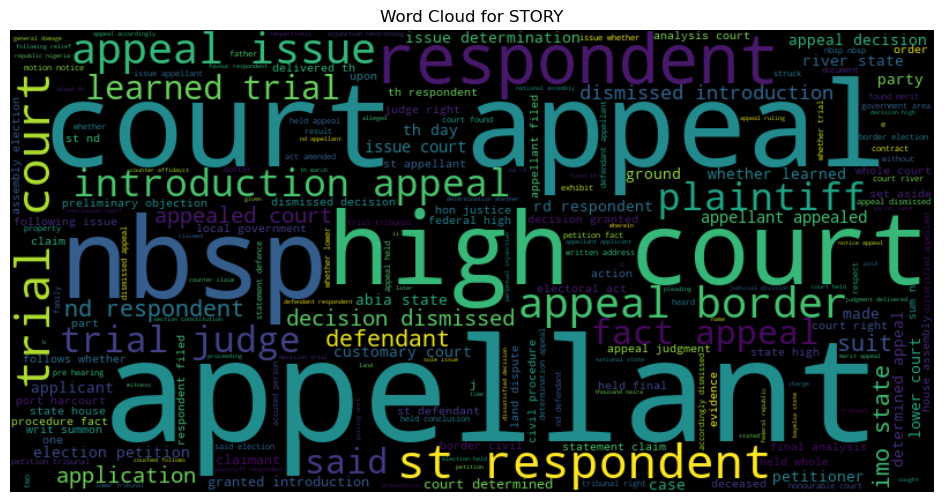

In [641]:
# Text Preprocessing: Clean and tokenize the text
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = re.sub('[^a-zA-Z]', ' ', str(text))  # Remove non-alphabetic characters
    text = text.lower()  # Convert to lowercase
    words = nltk.word_tokenize(text)  # Tokenize text into words
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatize and remove stopwords
    return ' '.join(words)

data['Cleaned_STORY'] = data['Altered_STORY'].apply(preprocess_text)

plt.figure(figsize=(12, 6))
wordcloud = WordCloud(width=800, height=400).generate(' '.join(data['Cleaned_STORY']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for STORY')
plt.show()

In [642]:
# Textual Features: TF-IDF Vectors
tfidf_vectorizer_story = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer_story.fit_transform(data['Cleaned_STORY']).toarray()

y = list(data['DECISION'])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"X.shape: {X.shape}\ny.shape: {y_encoded.shape}")
print(f"Classes of the first 10 Label and their corresponding number {list(zip(y[:10], y_encoded[:10]))}")

X.shape: (487, 5000)
y.shape: (487,)
Classes of the first 10 Label and their corresponding number [('Dismissed', 0), ('Dismissed', 0), ('Dismissed', 0), ('Partly Granted', 2), ('Dismissed', 0), ('Granted', 1), ('Dismissed', 0), ('Granted', 1), ('Dismissed', 0), ('Dismissed', 0)]


##### Class Balancing with SMOTE

Class imbalance occurs when one category significantly outweighs the others in a dataset as we see the 'Dismissed' Signficantly Outweighs 'Partially Granted.'

##### Challenges:  
Majority classes dominate, leading to biased model outputs.  
Minority classes receive insufficient attention, affecting their accurate classification.  


A Survey on Solution of Imbalanced Data Classification Problem Using Ensemble Learning Algorithms”: It discusses methods like SMOTE and ensemble learning for handling imbalanced data.


SMOTE is an oversampling technique used to address class imbalance in machine learning. It generates synthetic samples for the minority class, improving model performance.  The technique was introduced by Nitesh Chawla et al. in their 2002 paper titled “SMOTE: Synthetic Minority Over-sampling Technique”  

##### Algorithm Details:

The paper provides in-depth insights into how SMOTE works and its impact on imbalanced classification.

##### Formula:
Step 1: For each minority example, find its k-nearest neighbors based on Euclidean distance.  
Step 2: Set a sampling rate N (proportional to imbalance). Randomly select N examples from the neighbors.  
Step 3: Generate new examples using the following formula:  
New example = Original example + rand(0, 1) * (Neighbor example - Original example)  
Here, rand(0, 1) represents a random number between 0 and 1 

In [643]:
# Importing dataset, Pot Class Imbalance and prepare for Over/Under-sampling

smote = SMOTE()
# Apply class balancing
X, y_encoded = smote.fit_resample(X, y_encoded)

print('After the Smoth sampling: ')
print('Class Dismissed ', (y_encoded == 0).sum())
print('Class Granted ', (y_encoded == 1).sum())
print('Class Partly Granted ', (y_encoded == 2).sum())

After the Smoth sampling: 
Class Dismissed  296
Class Granted  296
Class Partly Granted  296


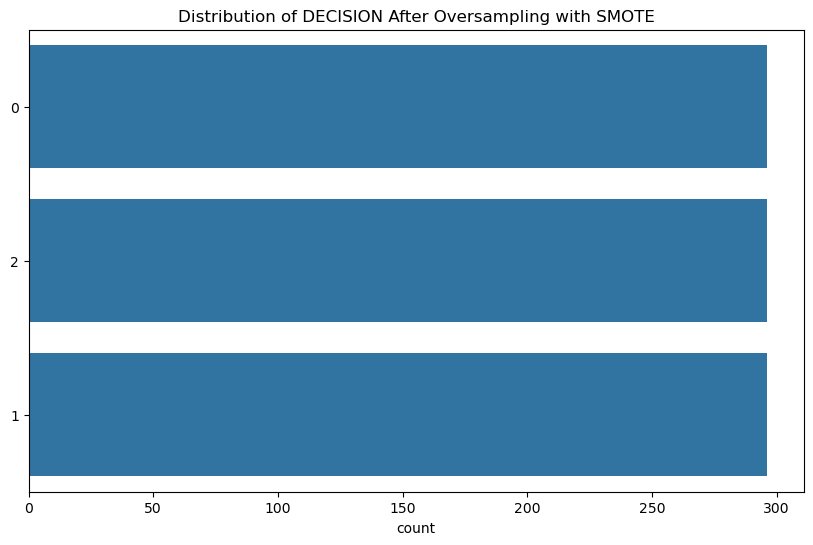

In [644]:
# Plot the distribution of CASE TITLE (displaying only top 20 for better visualization)
plt.figure(figsize=(10, 6))
sns.countplot(y=y_encoded, order=y_encoded)
plt.title('Distribution of DECISION After Oversampling with SMOTE')
plt.show()

In [645]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=52)

print("X_train.shape", X_train.shape)
print("X_test.shape", X_test.shape)
print("y_train.shape", y_train.shape)
print("y_test.shape", y_test.shape)

X_train.shape (710, 5000)
X_test.shape (178, 5000)
y_train.shape (710,)
y_test.shape (178,)


#### Logistic Regression

Logistic regression models the probability of a binary or multi-class outcome based on input features.  
It predicts the probability of an event (e.g., class membership) using a logistic function.  

 In our case, it can predict the legal case decision (Granted, Partly Granted, or Dismissed).

 ##### Logistic Regression Formula:
The logistic regression equation relates the log-odds of the outcome (success): $[ \text{logit}(p) = \frac{1}{1 + e^{-(b_0 + b_1x_1 + b_2x_2 + \ldots + b_px_p)}} ]$

(p): Probability of the positive outcome (e.g., being Granted).  
$(x_1, x_2, \ldots, x_p)$: Input features (e.g., STORY-related features).  
$(b_0, b_1, b_2, \ldots, b_p)$: Coefficients learned from training data.

##### Training

In [646]:
# Logistic Regression Training
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

##### Evaluating on Train Dataset

In [647]:
# Prediction with Trained model
y_train_pred_log_reg = log_reg.predict(X_train)

In [648]:
# Calculating accuracy and metric on training data
train_accuracy_log_reg = accuracy_score(y_train, y_train_pred_log_reg)
train_precision_log_reg = precision_score(y_train, y_train_pred_log_reg, average='macro')
train_recall_log_reg = recall_score(y_train, y_train_pred_log_reg, average='macro')
train_f1_log_reg = f1_score(y_train, y_train_pred_log_reg, average='macro')

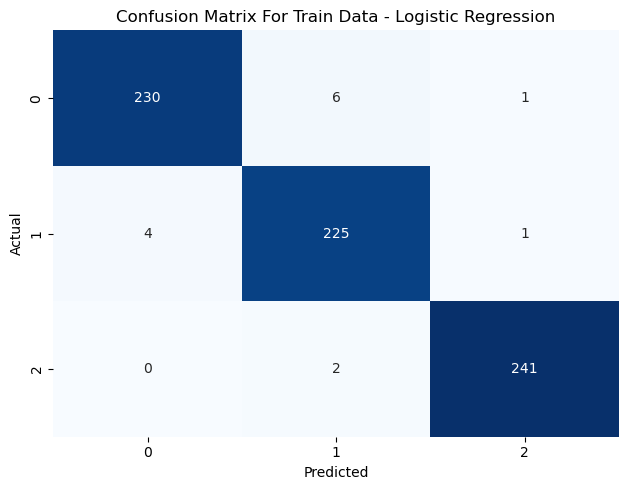

train_accuracy_log_reg: 98.02816901408451, 
train_precision_log_reg: 98.01135887608625, 
train_recall_log_reg: 98.01648506371392, 
train_f1_log_reg: 98.01124095965221


In [649]:
train_cm_log_reg = confusion_matrix(y_train, y_train_pred_log_reg)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix For Train Data - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()

print(f"train_accuracy_log_reg: {train_accuracy_log_reg*100}, \ntrain_precision_log_reg: {train_precision_log_reg*100}, \ntrain_recall_log_reg: {train_recall_log_reg*100}, \ntrain_f1_log_reg: {train_f1_log_reg*100}")

##### Evaluating on Test Dataset

In [650]:
# Prediction with Trained model
y_test_pred_log_reg = log_reg.predict(X_test)

In [651]:
# Calculating accuracy and metric on test data
test_accuracy_log_reg = accuracy_score(y_test, y_test_pred_log_reg)
test_precision_log_reg = precision_score(y_test, y_test_pred_log_reg, average='macro')
test_recall_log_reg = recall_score(y_test, y_test_pred_log_reg, average='macro')
test_f1_log_reg = f1_score(y_test, y_test_pred_log_reg, average='macro')

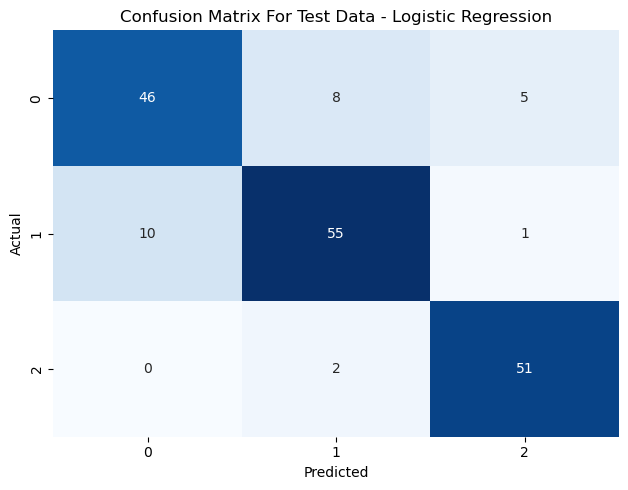

test_accuracy_log_reg: 85.39325842696628, 
test_precision_log_reg: 85.41064198958935, 
test_recall_log_reg: 85.84195004086274, 
test_f1_log_reg: 85.56557945870922


In [652]:
test_cm_log_reg = confusion_matrix(y_test, y_test_pred_log_reg)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(test_cm_log_reg, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix For Test Data - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()


print(f"test_accuracy_log_reg: {test_accuracy_log_reg*100}, \ntest_precision_log_reg: {test_precision_log_reg*100}, \ntest_recall_log_reg: {test_recall_log_reg*100}, \ntest_f1_log_reg: {test_f1_log_reg*100}")

#### Model Training Random Forest

Random Forests are powerful ensemble learning methods that combine multiple decision trees to make predictions.  
Random Forests are used for classification, regression, and other tasks. They create a multitude of decision trees during training.  
For classification tasks, the final prediction is the class selected by most trees.  

$[ \frac{N\_t}{N} \left( \text{impurity} - \frac{N\_{t_R}}{N\_t} \cdot \text{right\_impurity} - \frac{N\_{t\_L}}{N\_t} \cdot \text{left\_impurity} \right) ]$  
Random Forests mitigate decision trees’ tendency to overfit the training data.   
They use random subsets of features and bagging (bootstrap aggregating) to control variance.  
Random Forests handle nonlinearity in data better than linear regression.  

##### Formula:
The weighted impurity decrease equation for splitting nodes in a Random Forest is as follows:  $[ \frac{N_t}{N} \left( \text{impurity} - \frac{N\_{t_R}}{N\_t} \cdot \text{right\_impurity} - \frac{N\_{t\_L}}{N\_t} \cdot \text{left\_impurity} \right) ]$  
(N): Total number of samples.  
(N_t): Number of samples at the current node.  
$(N_{t_L})$: Number of samples in the left child.  
$(N_{t_R})$: Number of samples in the right child.

##### Training

In [653]:
# Random Forest Train
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

##### Evaluating on Train Dataset

In [654]:
# Prediction with Trained model
y_train_pred_rf = rf.predict(X_train)

In [655]:
# Calculating accuracy and metric on training data
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
train_precision_rf = precision_score(y_train, y_train_pred_rf, average='macro')
train_recall_rf = recall_score(y_train, y_train_pred_rf, average='macro')
train_f1_rf = f1_score(y_train, y_train_pred_rf, average='macro')

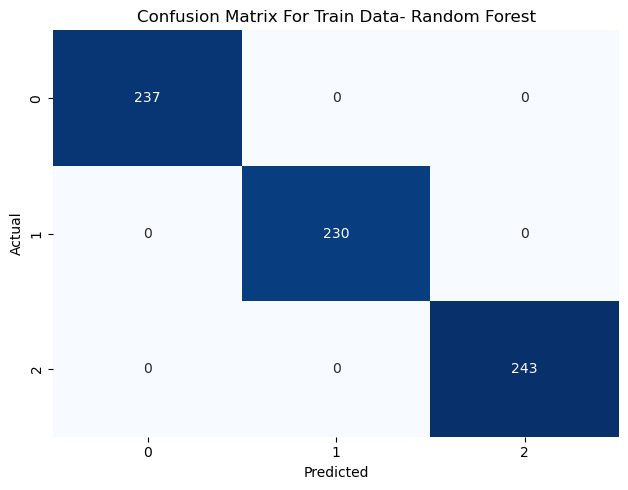

train_accuracy_rf: 100.0, 
train_precision_rf: 100.0, 
train_recall_rf: 100.0, 
train_f1_rf: 100.0


In [656]:
train_cm_rf = confusion_matrix(y_train, y_train_pred_rf)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix For Train Data- Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()

print(f"train_accuracy_rf: {train_accuracy_rf*100}, \ntrain_precision_rf: {train_precision_rf*100}, \ntrain_recall_rf: {train_recall_rf*100}, \ntrain_f1_rf: {train_f1_rf*100}")

##### Evaluating on Test Dataset

In [657]:
# Prediction with Trained model
y_test_pred_rf = rf.predict(X_test)

In [658]:
# Calculating accuracy and metric on test data
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
test_precision_rf = precision_score(y_test, y_test_pred_rf, average='macro')
test_recall_rf = recall_score(y_test, y_test_pred_rf, average='macro')
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='macro')

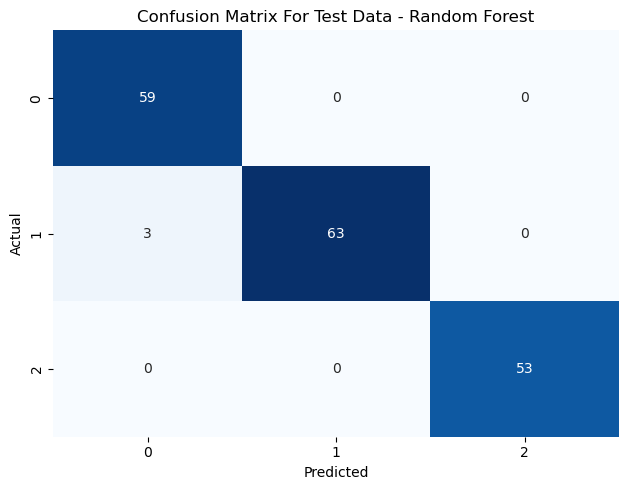

test_accuracy_rf: 98.31460674157303, 
test_precision_rf: 98.38709677419355, 
test_recall_rf: 98.48484848484848, 
test_f1_rf: 98.39835992055865


In [659]:
test_cm_rf = confusion_matrix(y_test, y_test_pred_rf)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(test_cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix For Test Data - Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()


print(f"test_accuracy_rf: {test_accuracy_rf*100}, \ntest_precision_rf: {test_precision_rf*100}, \ntest_recall_rf: {test_recall_rf*100}, \ntest_f1_rf: {test_f1_rf*100}")

#### Model Training  KNeighbors Classifier

In [660]:
# Random Forest Train
kn = KNeighborsClassifier()
kn.fit(X_train, y_train)

KNeighborsClassifier()

##### Evaluating on Train Dataset

In [661]:
# Prediction with Trained model
y_train_pred_kn = kn.predict(X_train)

In [662]:
# Calculating accuracy and metric on training data
train_accuracy_kn = accuracy_score(y_train, y_train_pred_kn)
train_precision_kn = precision_score(y_train, y_train_pred_kn, average='macro')
train_recall_kn = recall_score(y_train, y_train_pred_kn, average='macro')
train_f1_kn = f1_score(y_train, y_train_pred_kn, average='macro')

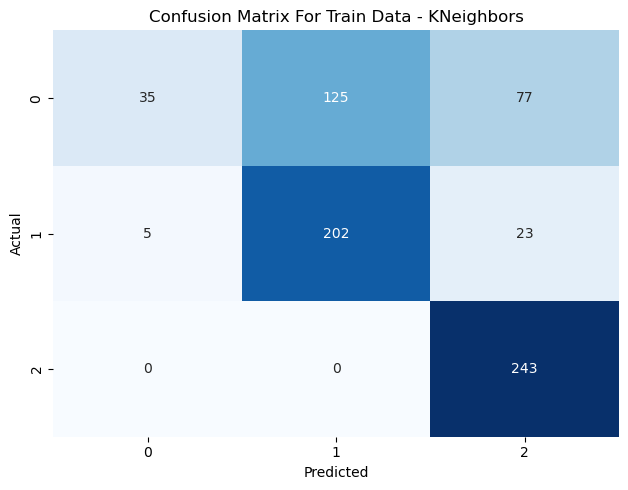

train_accuracy_kn: 67.6056338028169, 
train_precision_kn: 73.37306045179103, 
train_recall_kn: 67.53133981532442, 
train_f1_kn: 60.245776672916406


In [663]:
train_cm_kn = confusion_matrix(y_train, y_train_pred_kn)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_cm_kn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix For Train Data - KNeighbors')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()

print(f"train_accuracy_kn: {train_accuracy_kn*100}, \ntrain_precision_kn: {train_precision_kn*100}, \ntrain_recall_kn: {train_recall_kn*100}, \ntrain_f1_kn: {train_f1_kn*100}")

##### Evaluating on Test Dataset

In [664]:
# Prediction with Trained model
y_test_pred_kn = kn.predict(X_test)

In [665]:
# Calculating accuracy and metric on test data
test_accuracy_kn = accuracy_score(y_test, y_test_pred_kn)
test_precision_kn = precision_score(y_test, y_test_pred_kn, average='macro')
test_recall_kn = recall_score(y_test, y_test_pred_kn, average='macro')
test_f1_kn = f1_score(y_test, y_test_pred_kn, average='macro')

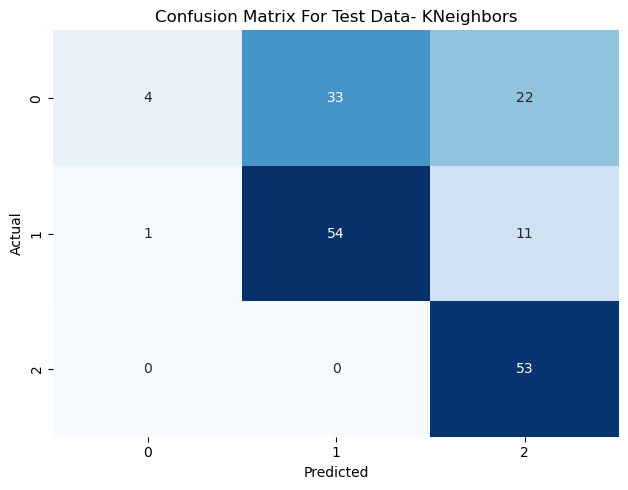

test_accuracy_kn: 62.35955056179775, 
test_precision_kn: 67.89895749799518, 
test_recall_kn: 62.865947611710325, 
test_f1_kn: 53.11574269995768


In [666]:
test_cm_kn = confusion_matrix(y_test, y_test_pred_kn)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(test_cm_kn, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix For Test Data- KNeighbors')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()


print(f"test_accuracy_kn: {test_accuracy_kn*100}, \ntest_precision_kn: {test_precision_kn*100}, \ntest_recall_kn: {test_recall_kn*100}, \ntest_f1_kn: {test_f1_kn*100}")

#### Model Training Naive Bayes

In [667]:
# Random Forest Train
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

##### Evaluating on Train Dataset

In [668]:
# Prediction with Trained model
y_train_pred_nb = nb.predict(X_train)

In [669]:
# Calculating accuracy and metric on training data
train_accuracy_nb = accuracy_score(y_train, y_train_pred_nb)
train_precision_nb = precision_score(y_train, y_train_pred_nb, average='macro')
train_recall_nb = recall_score(y_train, y_train_pred_nb, average='macro')
train_f1_nb = f1_score(y_train, y_train_pred_nb, average='macro')

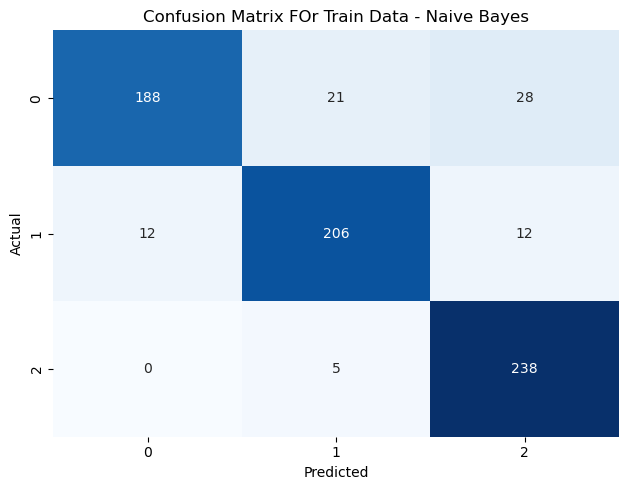

train_accuracy_nb: 89.01408450704226, 
train_precision_nb: 89.46820474654758, 
train_recall_nb: 88.94416624578267, 
train_f1_nb: 88.86048100812877


In [670]:
train_cm_nb = confusion_matrix(y_train, y_train_pred_nb)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix FOr Train Data - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()

print(f"train_accuracy_nb: {train_accuracy_nb*100}, \ntrain_precision_nb: {train_precision_nb*100}, \ntrain_recall_nb: {train_recall_nb*100}, \ntrain_f1_nb: {train_f1_nb*100}")

##### Evaluating on Test Dataset

In [671]:
# Prediction with Trained model
y_test_pred_nb = nb.predict(X_test)

In [672]:
# Calculating accuracy and metric on test data
test_accuracy_nb = accuracy_score(y_test, y_test_pred_nb)
test_precision_nb = precision_score(y_test, y_test_pred_nb, average='macro')
test_recall_nb = recall_score(y_test, y_test_pred_nb, average='macro')
test_f1_nb = f1_score(y_test, y_test_pred_nb, average='macro')

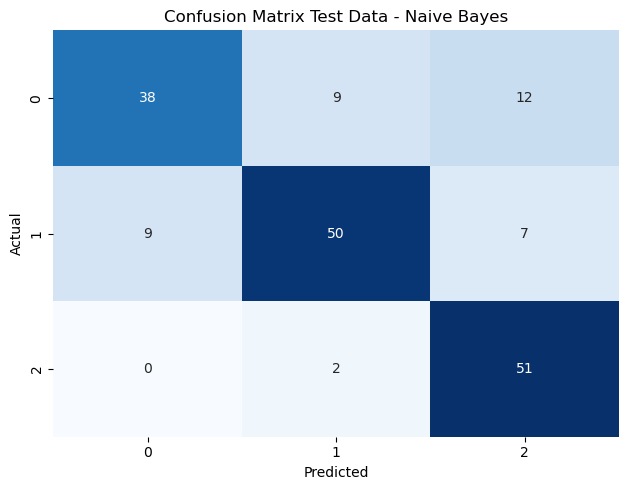

test_accuracy_nb: 78.08988764044943, 
test_precision_nb: 78.55847326722807, 
test_recall_nb: 78.79692350431077, 
test_f1_nb: 77.78836665205161


In [673]:
test_cm_nb = confusion_matrix(y_test, y_test_pred_nb)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(test_cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Test Data - Naive Bayes')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()


print(f"test_accuracy_nb: {test_accuracy_nb*100}, \ntest_precision_nb: {test_precision_nb*100}, \ntest_recall_nb: {test_recall_nb*100}, \ntest_f1_nb: {test_f1_nb*100}")

#### Model Training SVM Linear

SVM ( Support Vector Machine (SVM)) is a supervised machine learning algorithm used for classification and regression. It aims to find a hyperplane that best separates data points of different classes.  
In our case, SVM will classify legal cases into “Granted,” “Partly Granted,” or “Dismissed.  

Linear SVM assumes that the data is linearly separable.
It finds the optimal hyperplane (decision boundary) that maximizes the margin between classes.  
The decision boundary is defined by the equation: $[ f(X) = w^T \cdot X + b ]$    
$(w)$ is the weight vector.  
$(X)$ represents the data features.  
$(b)$ is the bias term (intercept).  
##### Margin and Support Vectors:  
SVM aims to maximize the margin (distance between the decision boundary and the nearest data points).
The data points closest to the decision boundary are called support vectors.
These support vectors determine the position of the decision boundary.

##### Mathematical Intuition:  
SVM seeks to find the weight vector (w) and bias term (b) that minimize the classification error while maximizing the margin.  
The decision function for a linear SVM is: $$ \hat{y} = \begin{cases} 1 : w^T \cdot X + b \geq 0   \\ 0  : w^T \cdot X + b < 0 \end{cases} $$

In [674]:
# Random Forest Train
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')

##### Evaluating on Train Dataset

In [675]:
# Prediction with Trained model
y_train_pred_svm = svm.predict(X_train)

In [676]:
# Calculating accuracy and metric on training data
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
train_precision_svm = precision_score(y_train, y_train_pred_svm, average='macro')
train_recall_svm = recall_score(y_train, y_train_pred_svm, average='macro')
train_f1_svm = f1_score(y_train, y_train_pred_svm, average='macro')

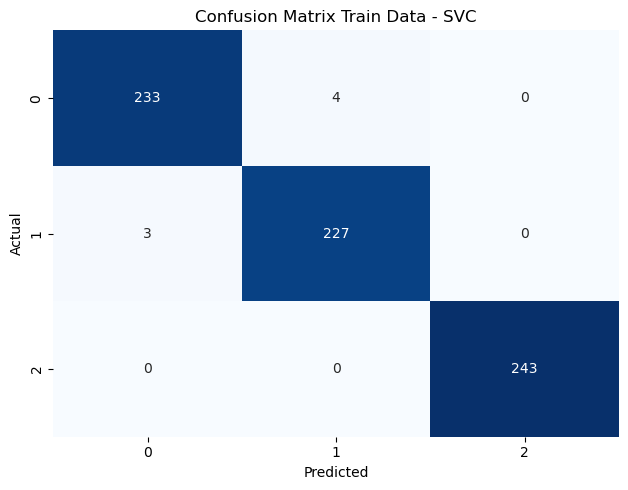

train_accuracy_svm: 99.01408450704226, 
train_precision_svm: 98.9990706092401, 
train_recall_svm: 99.0026294869443, 
train_f1_svm: 99.00054879624068


In [677]:
train_cm_svm = confusion_matrix(y_train, y_train_pred_svm)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(train_cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Train Data - SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()

print(f"train_accuracy_svm: {train_accuracy_svm*100}, \ntrain_precision_svm: {train_precision_svm*100}, \ntrain_recall_svm: {train_recall_svm*100}, \ntrain_f1_svm: {train_f1_svm*100}")

##### Evaluating on Test Dataset

In [678]:
# Prediction with Trained model
y_test_pred_svm = svm.predict(X_test)

In [679]:
# Calculating accuracy and metric on test data
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)
test_precision_svm = precision_score(y_test, y_test_pred_svm, average='macro')
test_recall_svm = recall_score(y_test, y_test_pred_svm, average='macro')
test_f1_svm = f1_score(y_test, y_test_pred_svm, average='macro')

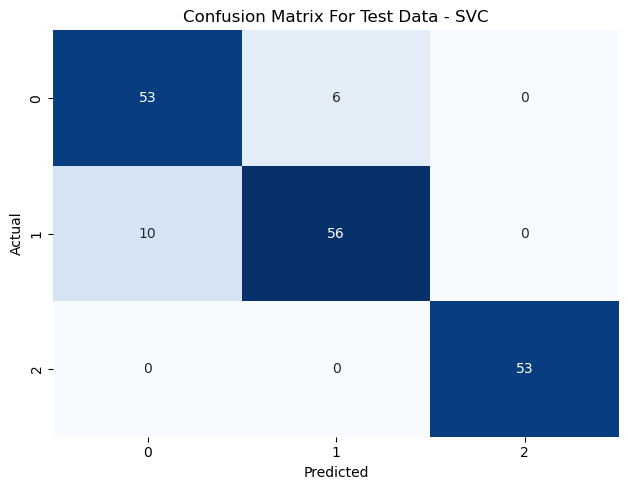

test_accuracy_svm: 91.01123595505618, 
test_precision_svm: 91.4831882573818, 
test_recall_svm: 91.55966444102037, 
test_f1_svm: 91.46174863387978


In [680]:
test_cm_svm = confusion_matrix(y_test, y_test_pred_svm)

# Plotting confusion matrices
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.heatmap(test_cm_svm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix For Test Data - SVC')
plt.xlabel('Predicted')
plt.ylabel('Actual')


plt.tight_layout()
plt.show()


print(f"test_accuracy_svm: {test_accuracy_svm*100}, \ntest_precision_svm: {test_precision_svm*100}, \ntest_recall_svm: {test_recall_svm*100}, \ntest_f1_svm: {test_f1_svm*100}")

#### Data Preparation for Deep Learning Models

In [681]:
# Get features and labels to train model with

X = (data['Cleaned_STORY'])

y = list(data['DECISION'])

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [682]:
# Split examples into train and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=52)

In [683]:
X_train.shape

(389,)

In [684]:
# Tokenize examples and fit on X_train

tokenizer = Tokenizer() 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
vocab_size = len(tokenizer.word_index)+1

# Pad the toekenized features at the end
X_train = pad_sequences(X_train, padding='post')

In [685]:
X_train.shape

(389, 761)

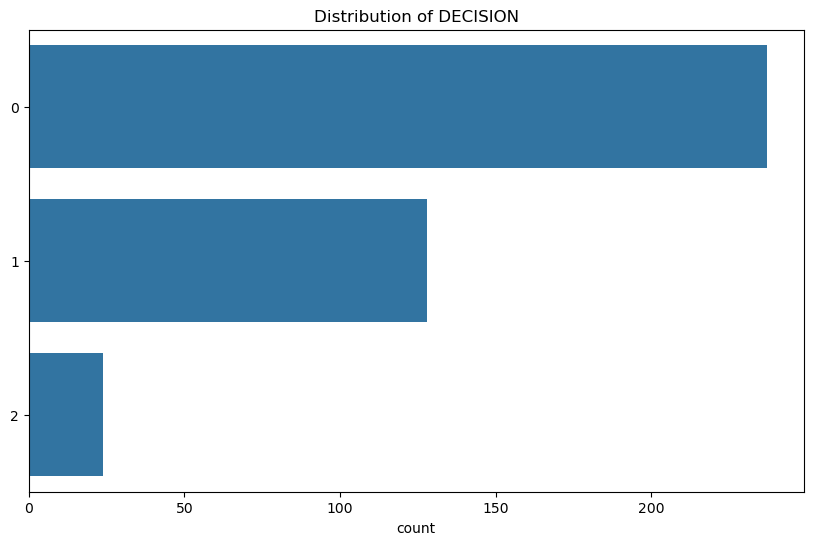

(389, 761),
 (389,)


In [686]:
# Plot the distribution of DECISION

plt.figure(figsize=(10, 6))
sns.countplot(y=y_train)
plt.title('Distribution of DECISION')
plt.show()
print(f"{X_train.shape},\n {y_train.shape}")

In [687]:
# Tokenize examples and fit on X_test
X_test = tokenizer.texts_to_sequences(X_test)

# Pad X_test at the end
X_test = pad_sequences(X_test, padding='post', maxlen = X_train.shape[1])

In [688]:
# One hot encoding of y_train
y_train = to_categorical(y_train)

# One hot encoding of y_test
y_test = to_categorical(y_test)

#### Simple RNN

 SimpleRNN is a basic type of recurrent neural network that can be used for sequential data tasks. SimpleRNN is a type of RNN architecture. It processes sequences step by step, maintaining hidden states. Useful for modeling sequential dependencies in text data. 
 ##### Formula:
The output of a SimpleRNN cell at time step (t) is computed as follows: $$[ h_t = \tanh(W \cdot X_t + U \cdot h_{t-1} + b) ]$$  
$(h_t)$: Hidden state at time step $(t)$.  
$(X_t)$: Input at time step $(t)$.  
$(W)$, $(U)$, and $(b)$: Learnable weights and bias.


In [689]:
def create_model_simple_rnn(max_sequence_length=100, vocab_size=20000, embedding_dim=200, rnn_units=128,
                 dense_units1=100, dense_units2=50, num_classes=3):
    # Input layer
    input_layer = Input(shape=(max_sequence_length,), dtype='int32')
    
    # Embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)
    
    # Vanilla RNN branch
    rnn_branch = SimpleRNN(rnn_units)(embedding_layer)
    
    # Dense layer
    dense_layer1 = Dense(dense_units1, activation='relu')(rnn_branch)
    
    # Dense layer
    dense_layer2 = Dense(dense_units2, activation='relu')(dense_layer1)

    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(dense_layer2)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [690]:
# Build the model
model_simple_rnn = create_model_simple_rnn(max_sequence_length=X_train.shape[1], 
                     vocab_size=vocab_size, 
                     embedding_dim=200,
                     rnn_units=128,
                     dense_units1=100,
                     dense_units2=50, 
                     num_classes=3)

model_simple_rnn.summary()

c:\Users\Public\anaconda3\envs\cluster_legal_cases\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 761)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_19 (Embedding)        │ (None, 761, 200)       │     1,241,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 128)            │        42,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 3)              │           153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,301,215 (4.96 MB)

 Trainable params: 1,301,215 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [691]:
# Train the model on X_train
history_simple_rnn = model_simple_rnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - accuracy: 0.4747 - loss: 0.9607 - val_accuracy: 0.6667 - val_loss: 0.8430
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.6197 - loss: 0.8493 - val_accuracy: 0.6667 - val_loss: 0.8721
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6172 - loss: 0.8514 - val_accuracy: 0.6667 - val_loss: 0.8450
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 613ms/step - accuracy: 0.5534 - loss: 0.9117 - val_accuracy: 0.6667 - val_loss: 0.8283
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 327ms/step - accuracy: 0.5703 - loss: 0.8880 - val_accuracy: 0.6667 - val_loss: 0.8461
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.6031 - loss: 0.8441 - val_accuracy: 0.6667 - val_loss: 0.8362
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 345ms/step - accuracy: 0.6092 - loss: 0.8322 - val_accuracy: 0.6667 - val_loss: 0.8432
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 328ms/step - accuracy: 0.5843 - loss: 0.8544 - val_accuracy: 0.6667 -

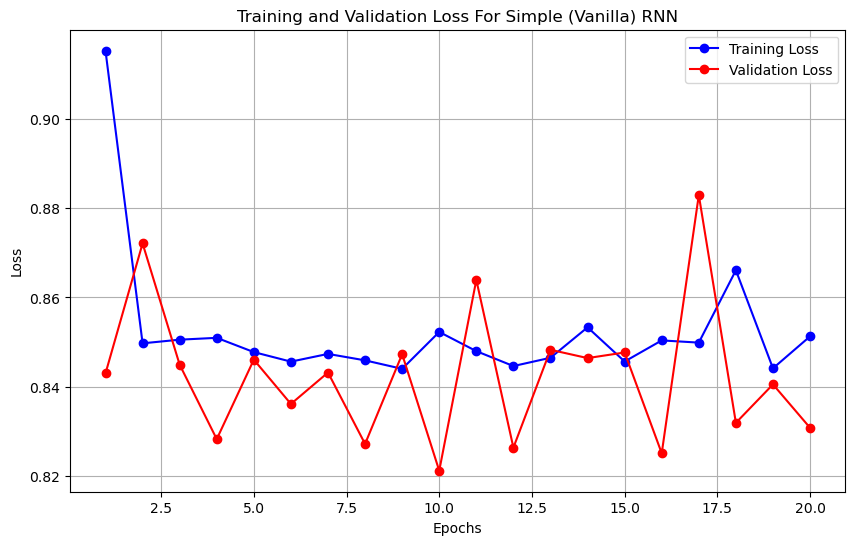

Train Loss For Simple (Vanilla) RNN: 85.13%
Validation Loss For Simple (Vanilla) RNN: 83.09%


In [692]:
# Plotting train and validation loss
train_loss_simple_rnn = history_simple_rnn.history['loss']
val_loss_simple_rnn = history_simple_rnn.history['val_loss']

# Creating epochs range
epochs = range(1, len(train_loss_simple_rnn) + 1)

# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_simple_rnn, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_simple_rnn, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss For Simple (Vanilla) RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Train Loss For Simple (Vanilla) RNN: {history_simple_rnn.history['loss'][-1] * 100:.2f}%")
print(f"Validation Loss For Simple (Vanilla) RNN: {history_simple_rnn.history['val_loss'][-1] * 100:.2f}%")

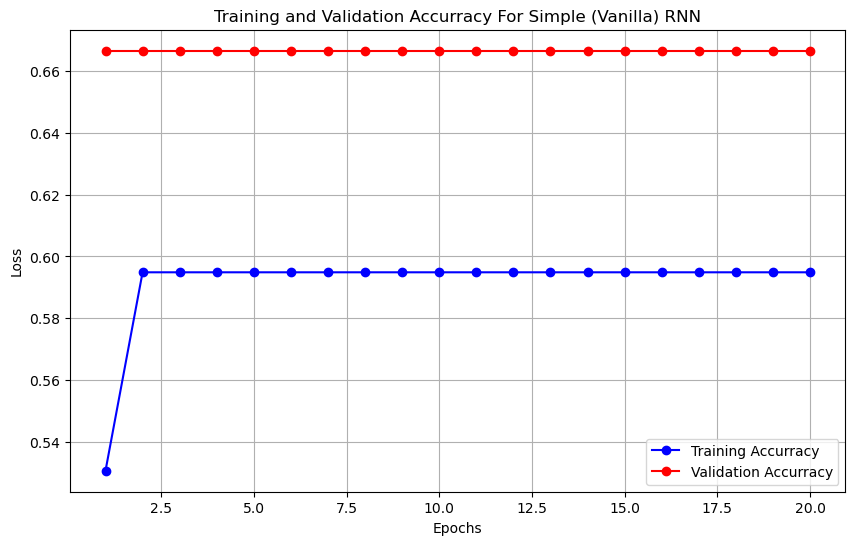

Train Accurracy For Simple (Vanilla) RNN: 59.49%
Validation Accurracy For Simple (Vanilla) RNN: 66.67%


In [693]:
# Plotting train and validation accuracy
train_accuracy_simple_rnn = history_simple_rnn.history['accuracy']
val_accuracy_simple_rnn = history_simple_rnn.history['val_accuracy']

# Creating epochs range
epochs = range(1, len(train_accuracy_simple_rnn) + 1)

# Plotting Acurracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_simple_rnn, 'bo-', label='Training Accurracy')
plt.plot(epochs, val_accuracy_simple_rnn, 'ro-', label='Validation Accurracy')
plt.title('Training and Validation Accurracy For Simple (Vanilla) RNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Train Accurracy For Simple (Vanilla) RNN: {history_simple_rnn.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation Accurracy For Simple (Vanilla) RNN: {history_simple_rnn.history['val_accuracy'][-1] * 100:.2f}%")

In [694]:
# Evaluate the model on Test data
loss_simple_rnn, accuracy_simple_rnn = model_simple_rnn.evaluate(X_test, y_test)

print(f'Test Accuracy For Simple (Vanilla) RNN: {accuracy_simple_rnn * 100:.2f}%')
print(f'Test Loss For Simple (Vanilla) RNN: {loss_simple_rnn * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5929 - loss: 0.8538
Test Accuracy For Simple (Vanilla) RNN: 60.20%
Test Loss For Simple (Vanilla) RNN: 86.33%


#### CNN (Conv1D)

Conv1D layers are commonly used for processing sequential data, such as text. Conv1D layers apply 1D convolutions to input sequences. They slide a filter (kernel) over the input, capturing local patterns. Useful for extracting features from sequential data (e.g., text, time series).

##### Formula:  
The output of a Conv1D layer is computed as follows: $$[ \text{output}[i] = \sum_{j=0}^{k-1} \text{input}[i+j] \cdot \text{kernel}[j] + \text{bias} ]$$
$(i)$: Position in the output sequence.  
$(k)$: Kernel size.  
$(\text{input})$: Input sequence.  
$(\text{kernel})$: Learnable weights (filter).  
$(\text{bias})$: Optional bias term.

In [695]:
# Create the CNN branch of the Deep Learning Model

def create_cnn_branch(embedding_layer, num_filters=150, region_sizes=[3, 5, 7]):
    cnn_layers = []
    for region_size in region_sizes:
        cnn_layer = Conv1D(filters=num_filters, kernel_size=region_size, activation='relu')(embedding_layer)
        cnn_layer = GlobalMaxPooling1D()(cnn_layer)
        cnn_layers.append(cnn_layer)
    cnn_concat = Concatenate()(cnn_layers) if len(cnn_layers) > 1 else cnn_layers[0]
    return cnn_concat

In [696]:
def create_model_cnn(max_sequence_length=100, vocab_size=20000, embedding_dim=200,
                     num_filters=150, region_sizes=[3, 5, 7], dense_units=100, num_classes=3):
    # Input layer
    input_layer = Input(shape=(max_sequence_length,), dtype='int32')
    
    # Embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)
    
    # Conv1D branch
    conv1d_branch = Conv1D(filters=num_filters, kernel_size=region_sizes[0], activation='relu')(embedding_layer)
    
    # Global max pooling
    pooled_layer = GlobalMaxPooling1D()(conv1d_branch)
    
    # Dense layer
    dense_layer = Dense(units=dense_units, activation='relu')(pooled_layer)
    
    # Output layer
    output_layer = Dense(units=num_classes, activation='softmax')(dense_layer)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [697]:
# Build the model
model_cnn = create_model_cnn(max_sequence_length=X_train.shape[1], 
                     vocab_size=vocab_size, 
                     embedding_dim=30,
                     num_filters=15, 
                     region_sizes=[3], 
                     dense_units=10, 
                     num_classes=3)

model_cnn.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 761)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_20 (Embedding)        │ (None, 761, 30)        │       186,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 759, 15)        │         1,365 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_9          │ (None, 15)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,708 (733.23 KB)

 Trainable params: 187,708 (733.23 KB)

 Non-trainable params: 0 (0.00 B)

In [698]:
# Train the model on X_train
history_cnn = model_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.1396 - loss: 1.1306 - val_accuracy: 0.6667 - val_loss: 1.0444
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5936 - loss: 1.0339 - val_accuracy: 0.6667 - val_loss: 0.9647
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5911 - loss: 0.9498 - val_accuracy: 0.6667 - val_loss: 0.8684
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5692 - loss: 0.8800 - val_accuracy: 0.6667 - val_loss: 0.7760
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6322 - loss: 0.7362 - val_accuracy: 0.6667 - val_loss: 0.6897
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6126 - loss: 0.6693 - val_accuracy: 0.6667 - val_loss: 0.6162
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6044 - loss: 0.5974 - val_accuracy: 0.7564 - val_loss: 0.5453
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7595 - loss: 0.5280 - val_accuracy: 0.8077 - v

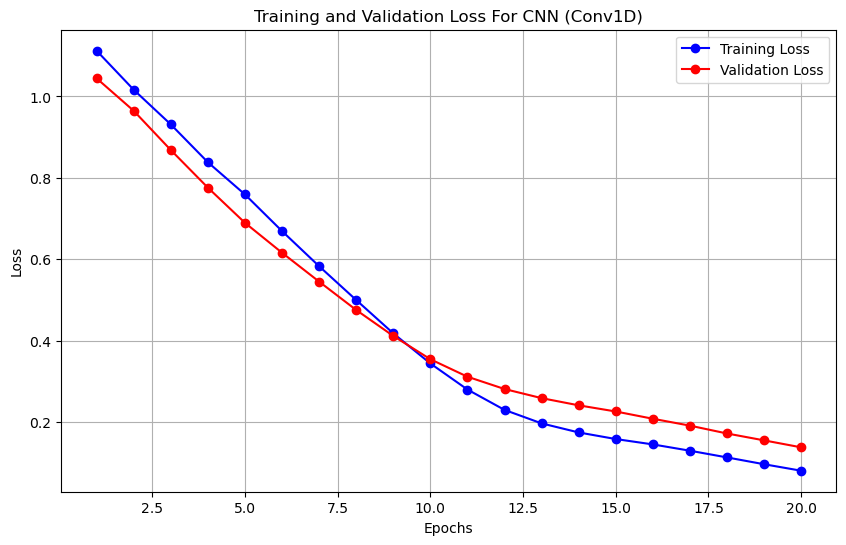

Train Loss For CNN (Conv1D): 8.11%
Validation Loss For CNN (Conv1D): 13.85%


In [699]:
# Plotting train and validation loss
train_loss_cnn = history_cnn.history['loss']
val_loss_cnn = history_cnn.history['val_loss']

# Creating epochs range
epochs = range(1, len(train_loss_cnn) + 1)

# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_cnn, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_cnn, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss For CNN (Conv1D)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Train Loss For CNN (Conv1D): {history_cnn.history['loss'][-1] * 100:.2f}%")
print(f"Validation Loss For CNN (Conv1D): {history_cnn.history['val_loss'][-1] * 100:.2f}%")

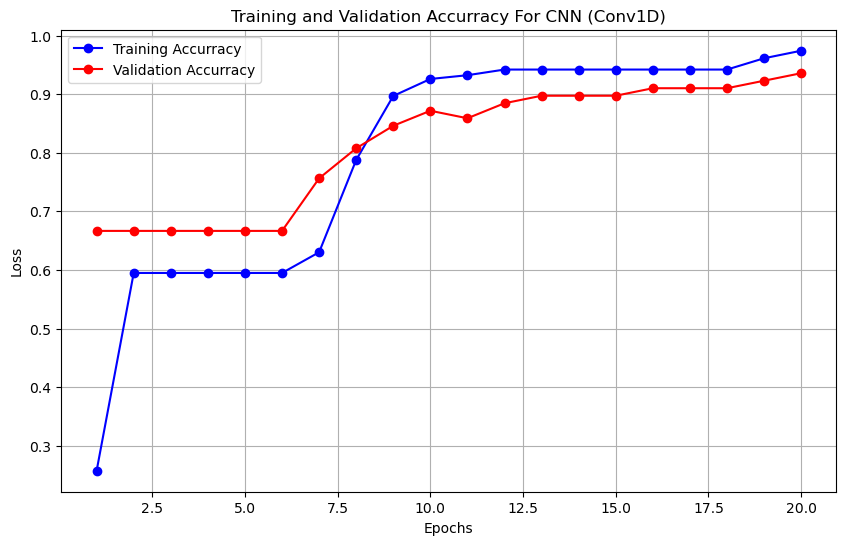

Train Accurracy For CNN (Conv1D): 97.43%
Validation Accurracy For CNN (Conv1D): 93.59%


In [700]:
# Plotting train and validation accuracy
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

# Creating epochs range
epochs = range(1, len(train_accuracy_cnn) + 1)

# Plotting Acurracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_cnn, 'bo-', label='Training Accurracy')
plt.plot(epochs, val_accuracy_cnn, 'ro-', label='Validation Accurracy')
plt.title('Training and Validation Accurracy For CNN (Conv1D)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Train Accurracy For CNN (Conv1D): {history_cnn.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation Accurracy For CNN (Conv1D): {history_cnn.history['val_accuracy'][-1] * 100:.2f}%")

In [701]:
# Evaluate the model on Test data
loss_cnn, accuracy_cnn = model_cnn.evaluate(X_test, y_test)

print(f'Test Accuracy For CNN (Conv1D): {accuracy_cnn * 100:.2f}%')
print(f'Test Loss For CNN (Conv1D): {loss_cnn * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9371 - loss: 0.1090 
Test Accuracy For CNN (Conv1D): 92.86%
Test Loss For CNN (Conv1D): 11.54%


#### Deep Learning with LSTMs

Long Short-Term Memory (LSTM) networks are powerful for sequence-based tasks, including text classification.  
LSTMs are a type of recurrent neural network (RNN) designed to handle long-term dependencies in sequential data. They address the vanishing gradient problem, allowing gradients to flow over extended time steps.

LSTM Formula:  
An LSTM cell consists of:  
A cell state $((C_t))$ that remembers information over time.  
Three gates: input gate $((i_t))$, forget gate $((f_t))$, and output gate $((o_t))$.  

The update equations for an LSTM cell are: $$[ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) ]$$ $$[ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) ]$$ $$[ C_t = f_t \cdot C_{t-1} + i_t \cdot \tanh(W_c \cdot [h_{t-1}, x_t] + b_c) ]$$ $$[ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) ]$$ $$[ h_t = o_t \cdot \tanh(C_t) ]$$

In [702]:
def create_model_lstm(max_sequence_length=100, vocab_size=20000, embedding_dim=200, lstm_units=128,
                 dense_units=100, num_classes=3):
    # Input layer
    input_layer = Input(shape=(max_sequence_length,), dtype='int32')
    
    # Embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)
    
    # LSTM branch
    lstm_branch = LSTM(lstm_units)(embedding_layer)
    
    # Dense layer
    dense_layer = Dense(dense_units, activation='relu')(lstm_branch)
    
    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


In [703]:
# Build the model
model_lstm = create_model_lstm(max_sequence_length=X_train.shape[1], 
                     vocab_size=vocab_size, 
                     embedding_dim=30,
                     lstm_units=15,
                     dense_units=10, 
                     num_classes=3)

model_lstm.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 761)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_21 (Embedding)        │ (None, 761, 30)        │       186,150 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 15)             │         2,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 10)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_50 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 189,103 (738.68 KB)

 Trainable params: 189,103 (738.68 KB)

 Non-trainable params: 0 (0.00 B)

In [704]:
# Train the model on X_train
history_lstm = model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.3187 - loss: 1.0739 - val_accuracy: 0.2692 - val_loss: 1.0201
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step - accuracy: 0.3468 - loss: 0.9839 - val_accuracy: 0.2692 - val_loss: 0.9505
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.4288 - loss: 0.9023 - val_accuracy: 0.6667 - val_loss: 0.9036
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step - accuracy: 0.6114 - loss: 0.8554 - val_accuracy: 0.6667 - val_loss: 0.8692
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - accuracy: 0.5726 - loss: 0.8681 - val_accuracy: 0.6667 - val_loss: 0.8500
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - accuracy: 0.5821 - loss: 0.8332 - val_accuracy: 0.6667 - val_loss: 0.8389
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.5660 - loss: 0.8655 - val_accuracy: 0.6667 - val_loss: 0.8387
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - accuracy: 0.6109 - loss: 0.8236 - val_accuracy: 0.

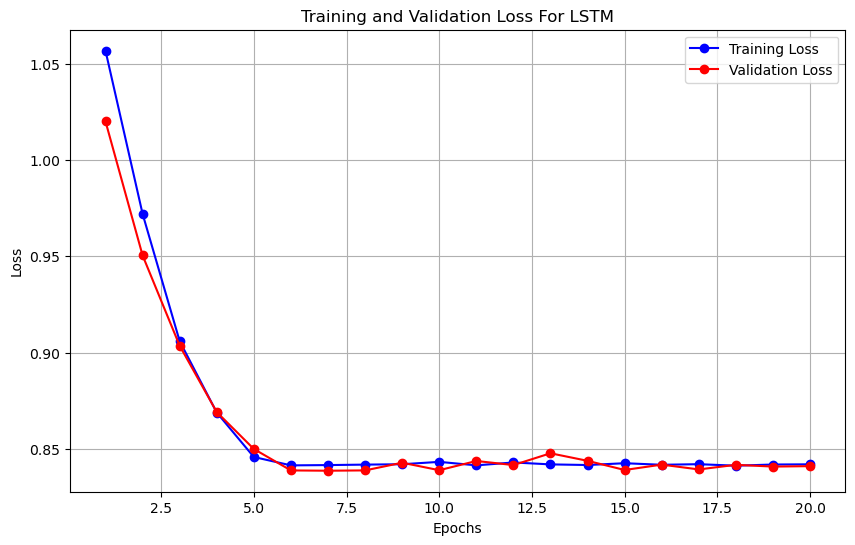

Train Loss For LSTM: 84.21%
Validation Loss For LSTM: 84.11%


In [705]:
# Plotting train and validation loss
train_loss_lstm = history_lstm.history['loss']
val_loss_lstm = history_lstm.history['val_loss']

# Creating epochs range
epochs = range(1, len(train_loss_lstm) + 1)

# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_lstm, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_lstm, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss For LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Train Loss For LSTM: {history_lstm.history['loss'][-1] * 100:.2f}%")
print(f"Validation Loss For LSTM: {history_lstm.history['val_loss'][-1] * 100:.2f}%")

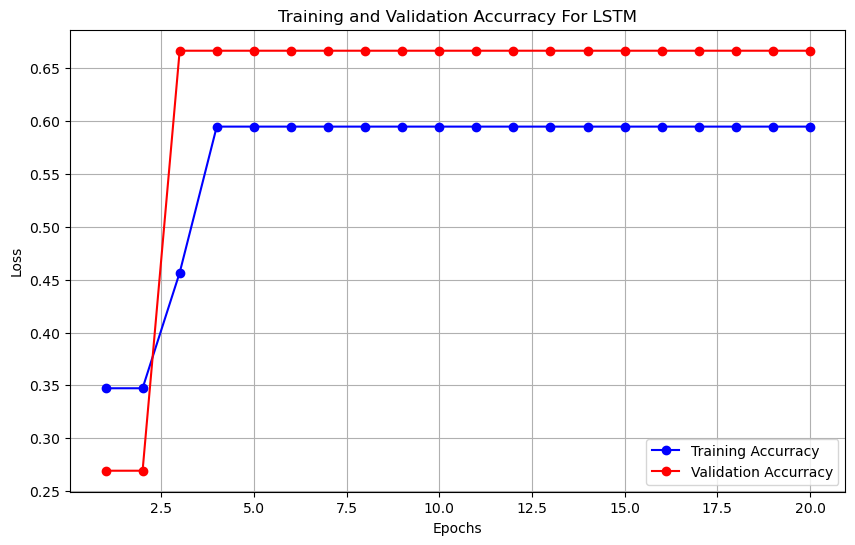

Train Accurracy For LSTM: 59.49%
Validation Accurracy For LSTM: 66.67%


In [706]:
# Plotting train and validation accuracy
train_accuracy_lstm = history_lstm.history['accuracy']
val_accuracy_lstm = history_lstm.history['val_accuracy']

# Creating epochs range
epochs = range(1, len(train_loss_lstm) + 1)

# Plotting Acurracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_lstm, 'bo-', label='Training Accurracy')
plt.plot(epochs, val_accuracy_lstm, 'ro-', label='Validation Accurracy')
plt.title('Training and Validation Accurracy For LSTM')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Train Accurracy For LSTM: {history_lstm.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation Accurracy For LSTM: {history_lstm.history['val_accuracy'][-1] * 100:.2f}%")

In [707]:
# Evaluate the model on Test data
loss_lstm, accuracy_lstm = model_lstm.evaluate(X_test, y_test)

print(f'Test Accuracy For LSTM: {accuracy_lstm * 100:.2f}%')
print(f'Test Loss For LSTM: {loss_lstm * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5929 - loss: 0.8514
Test Accuracy For LSTM: 60.20%
Test Loss For LSTM: 86.15%


### Deep Learning with combintation of LSTMs and CNN

Long Short-Term Memory (LSTM) networks are powerful for sequence-based tasks, including text classification.  
LSTMs are a type of recurrent neural network (RNN) designed to handle long-term dependencies in sequential data. They address the vanishing gradient problem, allowing gradients to flow over extended time steps.

LSTM Formula:  
An LSTM cell consists of:  
A cell state $((C_t))$ that remembers information over time.  
Three gates: input gate $((i_t))$, forget gate $((f_t))$, and output gate $((o_t))$.  

The update equations for an LSTM cell are: $$[ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) ]$$ $$[ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) ]$$ $$[ C_t = f_t \cdot C_{t-1} + i_t \cdot \tanh(W_c \cdot [h_{t-1}, x_t] + b_c) ]$$ $$[ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) ]$$ $$[ h_t = o_t \cdot \tanh(C_t) ]$$

Conv1D layers are commonly used for processing sequential data, such as text. Conv1D layers apply 1D convolutions to input sequences. They slide a filter (kernel) over the input, capturing local patterns. Useful for extracting features from sequential data (e.g., text, time series).

##### Formula:  
The output of a Conv1D layer is computed as follows: $$[ \text{output}[i] = \sum_{j=0}^{k-1} \text{input}[i+j] \cdot \text{kernel}[j] + \text{bias} ]$$
$(i)$: Position in the output sequence.  
$(k)$: Kernel size.  
$(\text{input})$: Input sequence.  
$(\text{kernel})$: Learnable weights (filter).  
$(\text{bias})$: Optional bias term.

In [708]:
# Create the CNN branch of the Deep Learning Model

def create_cnn_branch(embedding_layer, num_filters=150, region_sizes=[3, 5, 7]):
    cnn_layers = []
    for region_size in region_sizes:
        cnn_layer = Conv1D(filters=num_filters, kernel_size=region_size, activation='relu')(embedding_layer)
        cnn_layer = GlobalMaxPooling1D()(cnn_layer)
        cnn_layers.append(cnn_layer)
    cnn_concat = Concatenate()(cnn_layers) if len(cnn_layers) > 1 else cnn_layers[0]
    return cnn_concat

In [709]:
# Create the LSTM branck of the Deep Learning Model:

def create_lstm_branch(embedding_layer, lstm_units=128):
    lstm_layer = LSTM(lstm_units)(embedding_layer)
    return lstm_layer

In [710]:
# Create a Sequential Model and Incorporate the CNN and LSTM branches above.

def create_model_lstm_cnn(max_sequence_length=100, vocab_size=20000, embedding_dim=200, lstm_units=128, 
                 num_filters=150, region_sizes=[3, 5, 7], dense_units=100, num_classes=3):
    # Input layer
    input_layer = Input(shape=(max_sequence_length,), dtype='int32')
    
    # Embedding layer
    embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length)(input_layer)
    
    # CNN branch
    cnn_branch = create_cnn_branch(embedding_layer, num_filters=num_filters, region_sizes=region_sizes)
    
    # LSTM branch
    lstm_branch = create_lstm_branch(embedding_layer, lstm_units=lstm_units)
    
    # Concatenation
    concat_layer = Concatenate()([lstm_branch, cnn_branch])
    
    # Dense layer
    dense_layer = Dense(dense_units, activation='relu')(concat_layer)
    
    # Output layer
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)
    
    # Create the model
    model = Model(inputs=input_layer, outputs=output_layer)
    
    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [711]:
# Build the model
model_lstm_cnn = create_model_lstm_cnn(max_sequence_length=X_train.shape[1], 
                     vocab_size=vocab_size, 
                     embedding_dim=30, 
                     lstm_units=15, 
                     num_filters=15, 
                     region_sizes=[3], 
                     dense_units=10, 
                     num_classes=3)

model_lstm_cnn.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 761)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, 761, 30)   │    186,150 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 759, 15)   │      1,365 │ embedding_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_9 (LSTM)       │ (None, 15)        │      2,760 │ embedding_22[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 15)        │          0 │ conv1d_10[0][0]   │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 30)        │          0 │ lstm_9[0][0],     │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 10)        │        310 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 3)         │         33 │ dense_51[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 190,618 (744.60 KB)

 Trainable params: 190,618 (744.60 KB)

 Non-trainable params: 0 (0.00 B)

In [712]:
# Train the model on X_train
history_lstm_cnn = model_lstm_cnn.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.5744 - loss: 1.0001 - val_accuracy: 0.6667 - val_loss: 0.8687
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.5679 - loss: 0.8680 - val_accuracy: 0.6667 - val_loss: 0.8074
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.5842 - loss: 0.8190 - val_accuracy: 0.6667 - val_loss: 0.7896
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step - accuracy: 0.6022 - loss: 0.7219 - val_accuracy: 0.6667 - val_loss: 0.7491
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.6456 - loss: 0.6700 - val_accuracy: 0.7564 - val_loss: 0.6691
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.8698 - loss: 0.6497 - val_accuracy: 0.9231 - val_loss: 0.5631
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - accuracy: 0.9312 - loss: 0.4938 - val_accuracy: 0.9231 - val_loss: 0.4560
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 194ms/step - accuracy: 0.9375 - loss: 0.3887 - val_accuracy: 0.

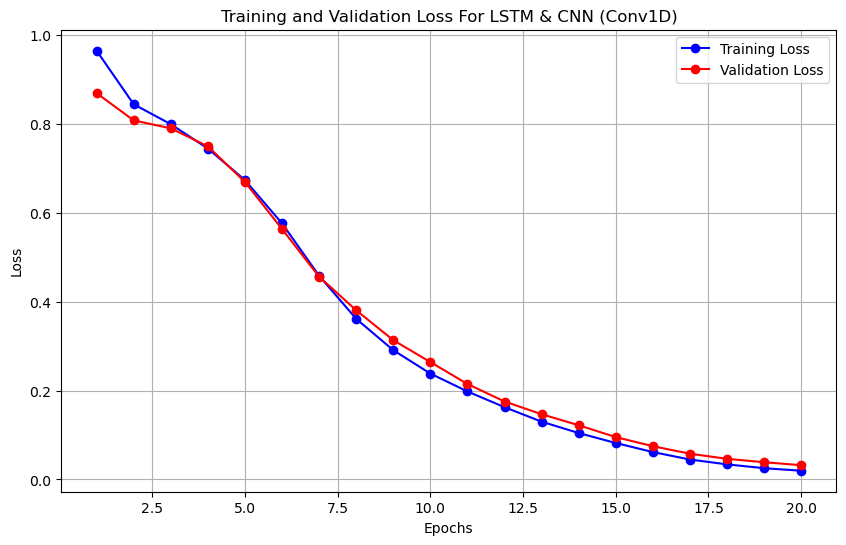

Train Loss For LSTM & CNN (Conv1D): 1.97%
Validation Loss For LSTM & CNN (Conv1D): 3.21%


In [713]:
# Plotting train and validation loss
train_loss_lstm_cnn = history_lstm_cnn.history['loss']
val_loss_lstm_cnn = history_lstm_cnn.history['val_loss']

# Creating epochs range
epochs = range(1, len(train_loss_lstm_cnn) + 1)

# Plotting loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_lstm_cnn, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss_lstm_cnn, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss For LSTM & CNN (Conv1D)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Train Loss For LSTM & CNN (Conv1D): {history_lstm_cnn.history['loss'][-1] * 100:.2f}%")
print(f"Validation Loss For LSTM & CNN (Conv1D): {history_lstm_cnn.history['val_loss'][-1] * 100:.2f}%")

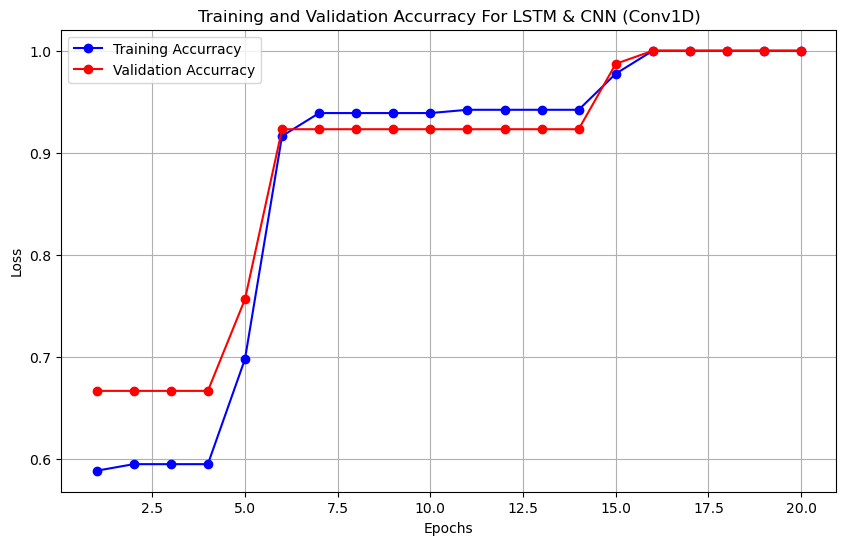

Train Accurracy For LSTM & CNN (Conv1D): 100.00%
Validation Accurracy For LSTM & CNN (Conv1D): 100.00%


In [714]:
# Plotting train and validation accuracy
train_accuracy_lstm_cnn = history_lstm_cnn.history['accuracy']
val_accuracy_lstm_cnn = history_lstm_cnn.history['val_accuracy']

# Creating epochs range
epochs = range(1, len(train_loss_lstm_cnn) + 1)

# Plotting Acurracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracy_lstm_cnn, 'bo-', label='Training Accurracy')
plt.plot(epochs, val_accuracy_lstm_cnn, 'ro-', label='Validation Accurracy')
plt.title('Training and Validation Accurracy For LSTM & CNN (Conv1D)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

print(f"Train Accurracy For LSTM & CNN (Conv1D): {history_lstm_cnn.history['accuracy'][-1] * 100:.2f}%")
print(f"Validation Accurracy For LSTM & CNN (Conv1D): {history_lstm_cnn.history['val_accuracy'][-1] * 100:.2f}%")

In [715]:
# Evaluate the model on Test data
loss_lstm_cnn, accuracy_lstm_cnn = model_lstm_cnn.evaluate(X_test, y_test)

print(f'Test Accuracy For LSTM & CNN (Conv1D): {accuracy_lstm_cnn * 100:.2f}%')
print(f'Test Loss For LSTM & CNN (Conv1D): {loss_lstm_cnn * 100:.2f}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 1.0000 - loss: 0.0198
Test Accuracy For LSTM & CNN (Conv1D): 100.00%
Test Loss For LSTM & CNN (Conv1D): 2.10%
